In [28]:
import functions
import matplotlib.pyplot as plt
import torch

from dataset import LamaHDataset
from models import FloodMLP, FloodGCN, FloodGRAFFNN
from torchinfo import summary
from tqdm import tqdm

In [6]:
chkpt = torch.load("runs/2023-04-07_11-48-08.run")
HPARAMS = chkpt["hparams"]
best_epoch = torch.tensor(chkpt["history"]["val_loss"]).argmin()
print(best_epoch)

In [9]:
dataset = LamaHDataset("LamaH-CE",
                       years=[2017],
                       window_size_hrs=HPARAMS["data"]["window_size"],
                       stride_length_hrs=HPARAMS["data"]["stride_length"],
                       lead_time_hrs=HPARAMS["data"]["lead_time"],
                       bidirectional=HPARAMS["data"]["bidirectional"],
                       normalize=HPARAMS["data"]["normalized"])

Loading dataset into memory...


100%|██████████| 375/375 [00:26<00:00, 14.05it/s]


In [10]:
model_params = chkpt["history"]["model_params"][best_epoch]
if HPARAMS["model"]["weight_type"] == "learned":
    edge_weights = model_params["edge_weights"]
else:
    edge_weights = functions.init_edge_weights(HPARAMS["model"]["weight_type"], dataset[0])
model = functions.construct_model(HPARAMS, edge_weights)
model.load_state_dict(model_params)

<All keys matched successfully>

In [11]:
summary(model, depth=2)

Layer (type:depth-idx)                   Param #
FloodGCN                                 --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       3,200
│    └─ReLU: 2-2                         --
├─Linear: 1-2                            129
├─ModuleList: 1-3                        --
│    └─GCNConv: 2-3                      16,512
│    └─GCNConv: 2-4                      16,512
│    └─GCNConv: 2-5                      16,512
│    └─GCNConv: 2-6                      16,512
│    └─GCNConv: 2-7                      16,512
│    └─GCNConv: 2-8                      16,512
│    └─GCNConv: 2-9                      16,512
│    └─GCNConv: 2-10                     16,512
│    └─GCNConv: 2-11                     16,512
│    └─GCNConv: 2-12                     16,512
│    └─GCNConv: 2-13                     16,512
│    └─GCNConv: 2-14                     16,512
│    └─GCNConv: 2-15                     16,512
│    └─GCNConv: 2-16                     16,512
│    └─GCNC

In [12]:
data = dataset[0]

In [13]:
model.eval()
test_loss = 0
with torch.no_grad():
    pbar = tqdm(dataset, desc="Testing")
    for data in pbar:
        pred, loss = model(data.x, data.edge_index, data.y)
        test_loss += loss.item() / len(dataset)
        pbar.set_postfix(test_loss=test_loss)
print(test_loss)

Testing: 100%|██████████| 1456/1456 [00:21<00:00, 67.82it/s, test_loss=0.0112] 

0.011214937534972267


In [20]:
torch.tensor(chkpt["history"]["val_loss"])

tensor([0.1589, 0.1628, 0.1230, 0.1165, 0.0766, 0.0785, 0.0766, 0.2528, 0.0383,
        0.0341, 0.0223, 0.0245, 0.0242, 0.0187, 0.0183, 0.0188, 0.0176, 0.0185,
        0.0169, 0.0175])

In [21]:
model.eval()
pred, loss = model(data.x, data.edge_index, data.y)

In [22]:
dataset.mean.shape

torch.Size([375])

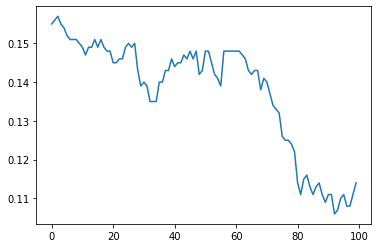

In [23]:
import matplotlib.pyplot as plt
plt.plot([(dataset.std * dataset[i].y + dataset.mean)[0,0] for i in range(100)])

In [26]:
start = 0
duration = 10
data = dataset[start]
ground_truth = torch.cat([data.x] + [dataset[i].y for i in range(duration)], dim=1)
prediction = torch.cat([data.x] + [torch.zeros(data.num_nodes, duration)], dim=1)
with torch.no_grad():
    for i in range(duration):
        j = data.x.size(1) + i
        x = prediction[:, i:j]
        y = ground_truth[:, j]
        prediction[:, j] = model(x, data.edge_index, y)[0].squeeze()
orig_preds = dataset.denormalize(prediction)
orig_targets = dataset.denormalize(ground_truth)

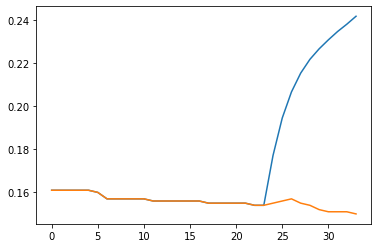

In [27]:
plt.plot(orig_preds[0])
plt.plot(orig_targets[0])

In [82]:
print(torch.cat([dataset[i].y[1] for i in range(10)]))

tensor([-0.7652, -0.7616, -0.7546, -0.7590, -0.7602, -0.7487, -0.7515, -0.7593,
        -0.7567, -0.7514])


In [87]:
print(torch.cat([targets[i][1] for i in range(10)]))

tensor([-0.7652, -0.7616, -0.7546, -0.7590, -0.7602, -0.7487, -0.7515, -0.7593,
        -0.7567, -0.7514])
